In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import time 

images = np.load("images.npy")
labels = np.load("labels.npy")

# Reshape images to (number of images, height*width)
images_reshaped = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
images_normed =  (images_reshaped - np.mean(images_reshaped, axis = 0))/np.std(images_reshaped, axis = 0)
NUM_IMAGES =  images_normed.shape[0]# number of images
NUM_VAL_IMAGES = NUM_IMAGES // 100
NUM_TRAIN_IMGAGES = NUM_IMAGES - NUM_VAL_IMAGES


indices = np.random.permutation(images_normed.shape[0])
training_idx, test_idx = indices[:NUM_TRAIN_IMGAGES], indices[NUM_TRAIN_IMGAGES:]
training_image_normed, test_image_normed = images_normed[training_idx,:], images_normed[test_idx,:]
training_label = labels[training_idx]
test_label = labels[test_idx]


In [20]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, ELEMENTS, D_H, NUM_CLASSES):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(ELEMENTS, D_H)
        self.linear2 = torch.nn.Linear(D_H, NUM_CLASSES)
#         self.drop_out = torch.nn.Dropout(0.1) #Dropout 


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """

        h_relu = F.relu(self.linear1(x))
        y_pred = self.linear2(h_relu) 


        return y_pred
    
def approx_train_accuracy(y_hat, labels):
    """Compute accuracy.
    
        Args:
            y: A 1-D int NumPy array.
            y_hat: A 1-D int NumPy array.
        Returns:
            A float, the fraction of time y[i] == y_hat[i].
    """

    labels = labels.detach().numpy()
    y_hat = y_hat.detach().numpy()

    return np.sum(y_hat==labels)/float(labels.size)
 
    

def train(batch_size, train_seqs, train_labels):
    # i is is a 1-D array with shape [batch_size]
    
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)

    x = torch.from_numpy(train_seqs[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.int))
    # Forward pass: Compute predicted y by passing x to the model
    y_hat_ = model(x)
    
    # Compute and print loss
    loss = F.cross_entropy(y_hat_, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

train_accs, val_accs = [], []
NUM_OPT_STEPS = 5000
batch_size = 10

ELEMENTS = images_reshaped.shape[1]# length of the image vector 
D_H = 100 # numbers of hidden layers 
NUM_CLASSES = 5 # number of classes
model = TwoLayerNet(ELEMENTS, D_H,NUM_CLASSES)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
correct = []
accs = []
failed_stored = []
start = time.time()
correct_val = []
images_val = test_image_normed
labels_val = test_label
acc_val = []
accuracy = []
total = len(labels_val)
index_store = []
train_accs, val_accs = [], []
val_correct = []

for i in range(NUM_OPT_STEPS):

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-6) #Create an SGD optimizer
    train(batch_size,images_normed,labels )
    
    loss= train(batch_size,training_image_normed,training_label )

    if i % 100 == 0:
        radom_index = np.random.choice(training_image_normed.shape[0], size= 1000, replace=False)
        x_acc = torch.from_numpy(training_image_normed[radom_index].astype(np.float32))
        y_acc = torch.from_numpy(training_label[radom_index].astype(np.int))
        y_hat_acc = model(x_acc)
        _, y_pred = torch.max(y_hat_acc,1)
        accuracy = np.sum((y_pred==y_acc).detach().numpy())/(y_acc.size())
        train_accs.append(accuracy*100)
        index_store.append(i)
 
        with torch.no_grad():
            val_correct = []
            for j in range(labels_val.shape[0]):
                x_val = torch.from_numpy(images_val[j].astype(np.float32))
                outputs = model(x_val)
                predicted = torch.max(outputs, 0)[1]
                val_correct.append((predicted.item() == labels_val[j]).sum().item())
           
            total = len(labels_val)
            val_accs.append((np.sum(val_correct) / total) * 100)
            val_ac = (np.sum(val_correct) / total) * 100
        print("Training Accyracy: ",accuracy*100, "validation accuracy: ",val_ac )
        

end = time.time()
print(end - start)



Training Accyracy:  [25.1] validation accuracy:  29.799999999999997
Training Accyracy:  [75.1] validation accuracy:  75.6
Training Accyracy:  [75.8] validation accuracy:  78.4
Training Accyracy:  [76.7] validation accuracy:  76.8
Training Accyracy:  [77.9] validation accuracy:  77.2
Training Accyracy:  [77.7] validation accuracy:  76.2
Training Accyracy:  [79.3] validation accuracy:  77.2
Training Accyracy:  [76.] validation accuracy:  78.2
Training Accyracy:  [78.9] validation accuracy:  80.4
Training Accyracy:  [80.] validation accuracy:  78.8
Training Accyracy:  [77.] validation accuracy:  78.60000000000001
Training Accyracy:  [81.] validation accuracy:  77.8
Training Accyracy:  [77.1] validation accuracy:  81.8
Training Accyracy:  [78.5] validation accuracy:  80.4
Training Accyracy:  [80.5] validation accuracy:  80.80000000000001
Training Accyracy:  [80.7] validation accuracy:  80.2
Training Accyracy:  [80.8] validation accuracy:  81.8
Training Accyracy:  [77.8] validation accuracy

Text(0, 0.5, 'Accuracy %')

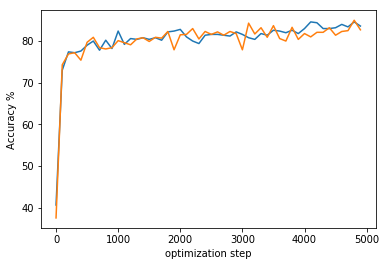

In [15]:
plt.plot(index_store, val_accs, index_store, train_accs)

plt.xlabel("optimization step")
plt.ylabel("Accuracy %")